In [47]:
import numpy as np
import pandas as pd
import mygene

from bokeh.io import output_notebook
from bokeh.plotting import figure, show, ColumnDataSource
from bokeh.models import HoverTool
from matplotlib import pyplot as plt

output_notebook()
%matplotlib inline

Loading BokehJS ...

### Prep-processing raw TF + gene file

In [20]:
# preprocessing transcription factor + gene regulation list
# filename = "../data/TF_network/pathway_extensions_v2.transcriptional.listt"
# cols = ["TF"] + ["gene"+str(i) for i in range(2500)]
# df = pd.read_csv(filename, names=cols, delimiter="\t", low_memory=False)
# valid_cols = df.columns[~df.isnull().all()]
# df = df[valid_cols]
# df.replace(np.nan, 0).to_csv("../data/TF_network/TF_gene.csv", index=None)

### convert TF+gene file into a matrix of 0s and 1s

In [ ]:
df = pd.read_csv("../data/TF_network/TF_gene.csv", low_memory=False)
pathway_genes = sorted(list(set(df.as_matrix().flatten())))
pathway_genes.remove('0')
assert(len(df["TF"]) == len(set(df["TF"])))
assert(len(pathway_genes) == len(set(pathway_genes)))
TFs = sorted(list(df["TF"]))

df_mask = pd.DataFrame(index=TFs, columns=pathway_genes)
for row_idx, TF in enumerate(TFs):
    if row_idx % 500 == 0:
        print(row_idx)
    TF_genes = set(df[df.TF == TF].as_matrix().flatten())
    TF_genes.remove('0')
    Not_TF_genes = [i for i in pathway_genes if i not in TF_genes]
    df_mask.loc[TF, TF_genes] = 1 
    df_mask.loc[TF, Not_TF_genes] = 0
df_mask.to_csv("../data/TF_network/TF_gene_matrix.csv")
df_mask.to_hdf("../data/TF_network/TF_gene_matrix.hdf", "TF")

### filter for genes that exist in TCGA

In [75]:
tcga_genes = list(pd.read_csv("../data/gene_ids.txt", header=None)[0])
tcga_genes = [i.split("|")[0] for i in tcga_genes]
df_mask = pd.read_hdf("../data/TF_network/TF_gene_matrix.hdf")
pathway_genes = list(df_mask.columns)
common_genes = sorted(list(set(tcga_genes).intersection(pathway_genes)))

print("number of genes in tcga", len(set(tcga_genes)))
print("number of genes in pathway", len(pathway_genes))
print("number of common genes between tcga and pathway", len(common_genes))

df_mask_tcga = df_mask[common_genes]
common_tfs = [i for i in df_mask.index if i in common_genes]
df_mask_tcga = df_mask_tcga.loc[common_tfs]

print("shape of TF_gene_matrix after filtering for genes existing in TCGA:")
print(df_mask_tcga.shape)

df_mask_tcga.to_hdf("../data/TF_network/TF_gene_matrix_filtered_by_tcga.hdf", "TF")
df_mask_tcga.to_csv("../data/TF_network/TF_gene_matrix_filtered_by_tcga.csv")

number of genes in tcga 16331
number of genes in pathway 14237
number of common genes between tcga and pathway 11104


### Histogram of number of genes a TF regulates

In [101]:
df = pd.read_hdf("../data/TF_network/TF_gene_matrix_filtered_by_tcga.hdf")

In [175]:
tf_gene_num = df.sum(axis=1).value_counts()
tf_gene_num_cumsum = tf_gene_num.sort_index().cumsum()
tf_gene_num_left = tf_gene_num.sum()-tf_gene_num.sort_index().cumsum()

In [188]:
source = ColumnDataSource(data=dict(
                          TF_num_genes=list(tf_gene_num_cumsum.index.astype(int)),
                          sum_count=list(tf_gene_num_cumsum),
                          tf_left=list(tf_gene_num_left)))
hover = HoverTool(tooltips=[("num genes", "@TF_num_genes"),("sum count", "@sum_count"), ("num left", "@tf_left")])

p = figure(height=400, width=800, x_axis_type="log",tools=[hover, "box_zoom", "reset"])
p.circle("TF_num_genes", "sum_count", color="blue", size=6, source=source)
p.circle("TF_num_genes", "tf_left", color="red", size=6, source=source)
p.xaxis.axis_label = "Number of genes a TF regulates"
p.yaxis.axis_label = "count"
show(p)

/home/molly/anaconda3/lib/python3.6/site-packages/bokeh/core/json_encoder.py:80: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(type(obj), np.float):


### Calculate sparsity 

In [2]:
df_tcga = pd.read_hdf("../data/TF_network/TF_gene_matrix_filtered_by_tcga.hdf")
df = pd.read_hdf("../data/TF_network/TF_gene_matrix.hdf")

In [199]:
for name, each_df in [("all pathway genes", df), ("only tcga genes", df_tcga)]:
    sparse_connections = int(each_df.sum().sum())
    fc_connections = each_df.shape[0] * each_df.shape[1]
    sparsity = sparse_connections/fc_connections
    print("for all genes existing in {0}: {1}/{2}={3:.2f}%".format(
        name, sparse_connections, fc_connections, sparsity*100))

for all genes existing in all pathway genes: 79581/95886195=0.08%
for all genes existing in only tcga genes: 60366/61760448=0.10%


### save TCGA mRNA expression version with only genes in pathway

In [89]:
df_tcga = pd.read_hdf("../data/TF_network/TF_gene_matrix_filtered_by_tcga.hdf")
tcga_genes = list(pd.read_csv("../data/gene_ids.txt", header=None)[0])
tcga_pathway_genes = [i for i in tcga_genes if i.split("|")[0] in df_tcga.columns]
pd.DataFrame(tcga_pathway_genes)[0].to_csv("../data/gene_ids_tcga&pathway.txt", index=None)
mRNA_df = pd.read_hdf("../data/mRNA_lognorm_StandardScaled.hdf", "mRNA")
mRNA_df[tcga_pathway_genes].to_hdf(
    "../data/TF_network/mRNA_lognorm_StandardScaled_pathway_genes.hdf", "mRNA")

In [93]:
df = pd.read_hdf("../data/TF_network/mRNA_lognorm_StandardScaled_pathway_genes.hdf", "mRNA")

In [94]:
def histogram_plotter(X, title, bins=50, xlim=None):
    sample = np.random.choice(X.as_matrix().flatten(), size=1000000)
    plt.hist(sample, bins=bins)
    if xlim:
        plt.xlim(xlim)
    plt.title(title)
    plt.show() 

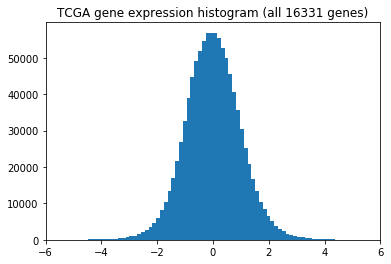

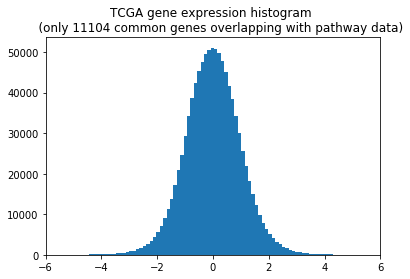

In [95]:
histogram_plotter(mRNA_df, "TCGA gene expression histogram (all 16331 genes)", 
                  bins=200, xlim=[-6, 6])
histogram_plotter(df, "TCGA gene expression histogram \n\
    (only 11104 common genes overlapping with pathway data)",
    bins=200, xlim=[-6, 6])

### make sure all genes in mRNA and mask are in the same order, and tranposing mask

In [ ]:
# make sure all genes are in the right order and trapose 
mRNA_file = "../data/TF_network/mRNA_lognorm_StandardScaled_pathway_genes.hdf"
weights_mask = "../data/TF_network/TF_gene_matrix_filtered_by_tcga.hdf"
mRNA_df = pd.read_hdf(mRNA_file, "mRNA")
weights_df = pd.read_hdf(weights_mask)

sorted_gene_ids = sorted(list(mRNA_df.columns))
sorted_genes = [i.split("|")[0] for i in sorted_gene_ids]

mRNA_df = mRNA_df[sorted_gene_ids]
weights_df = weights_df[sorted_genes].transpose()

x1 = np.array([i.split("|")[0] for i in mRNA_df.columns])
x2 = np.array(weights_df.index)

assert((x1==x2).all())
weights_df.to_hdf("../data/TF_network/TF_gene_matrix_filtered_by_tcga.hdf", "mask")